In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
from pathlib import Path

FEATURES_CSV = r"C:\Users\ASUS\Desktop\bababa\cluster\code_features2000.csv"
LABELS_CSV   = r"C:\Users\ASUS\Desktop\bababa\cluster\label.csv"        # code_id,label (0/1)

EMBED_MODEL  = "codebert"                          # "codebert" | "codet5"
BATCH_SIZE   = 16
MAX_TOKENS   = 512
POOLING      = "mean"                               # "cls" | "mean"


In [79]:
import os, pandas as pd

df = pd.read_csv(FEATURES_CSV)
labels = pd.read_csv(LABELS_CSV)
assert {"code_id","label"}.issubset(labels.columns)

def _base(p): return os.path.basename(str(p)).lower()
df["_k_base"] = df["code_id"].map(_base)
labels["_k_base"] = labels["code_id"].map(_base)

data = df.merge(labels[["_k_base","label"]], on="_k_base", how="inner")
print("Matched rows:", len(data), "/", len(df))

from pathlib import Path
def read_text_safely(path):
    try:
        return Path(path).read_text(encoding="utf-8", errors="ignore")
    except Exception:
        return ""

data["code_text"] = data["code_id"].map(read_text_safely)
data[["code_id","label","code_text"]].head(2)


Matched rows: 2036 / 2036


,code_id,label,code_text
0,C:\Users\ASUS\Desktop\bababa\Mix\149828_1.py,0,print('Hello Python!')
1,C:\Users\ASUS\Desktop\bababa\Mix\149828_1.py,0,print('Hello Python!')


In [80]:
# ----call codetbert start---
import torch, numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

def load_model_tokenizer(which="codebert"):
    if which == "codebert":
        name = "microsoft/codebert-base"
    elif which == "codet5":
        name = "Salesforce/codet5-base"
    else:
        raise ValueError("EMBED_MODEL must be 'codebert' or 'codet5'")

    name = "microsoft/codebert-base"
    tok = AutoTokenizer.from_pretrained(name, trust_remote_code=True)
    mdl = AutoModel.from_pretrained(
        name,
        trust_remote_code=True,
        use_safetensors=True   # << สำคัญ
    )
    return tok, mdl

def embed_batch(texts, tokenizer, model, max_tokens=512, pooling="cls", device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    vecs = []
    for t in texts:
        enc = tokenizer(t or "", return_tensors="pt", truncation=True, max_length=max_tokens)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
        last_hidden = out.last_hidden_state  # [1, T, H]
        if pooling == "cls":
            v = last_hidden[:,0,:].squeeze(0).detach().cpu().numpy()
        else:  # mean pooling
            v = last_hidden.mean(dim=1).squeeze(0).detach().cpu().numpy()
        vecs.append(v)
    return np.vstack(vecs)


In [81]:
tokenizer, model = load_model_tokenizer(EMBED_MODEL)

texts = data["code_text"].fillna("").tolist()
emb_list = []
for i in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch = texts[i:i+BATCH_SIZE]
    emb = embed_batch(batch, tokenizer, model, max_tokens=MAX_TOKENS, pooling=POOLING)
    emb_list.append(emb)
embeddings = np.vstack(emb_list)
embeddings.shape
# ----call codetbert end---


100%|██████████| 128/128 [00:38<00:00,  3.32it/s]


(2036, 768)

In [52]:
# ----call codet5 start---
from transformers import AutoTokenizer, AutoModel
name = "Salesforce/codet5p-110m-embedding"
tokenizer = AutoTokenizer.from_pretrained(name, trust_remote_code=True)
model = AutoModel.from_pretrained(name, trust_remote_code=True, use_safetensors=True)


In [53]:

import torch
import numpy as np

def mean_pooling(last_hidden_state, attention_mask):
    # last_hidden_state: [B, T, H], attention_mask: [B, T]
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    summed = (last_hidden_state * mask).sum(dim=1)         # [B, H]
    counts = mask.sum(dim=1).clamp(min=1e-9)               # [B, 1]
    return summed / counts

def embed_batch(texts, tokenizer, model, max_tokens=512, pooling="mean", device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_tokens
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        out = model(**enc)

    # CASE 1: โมเดลคืน Tensor ตรง ๆ (เช่น codet5p-110m-embedding)
    if isinstance(out, torch.Tensor):
        if out.dim() == 2:         # [B, H] → พร้อมใช้
            return out.detach().cpu().numpy()
        elif out.dim() == 3:       # [B, T, H] → ทำ pooling
            return mean_pooling(out, enc.get("attention_mask", torch.ones_like(enc["input_ids"]))).detach().cpu().numpy()

    # CASE 2: โมเดลคืน object ที่มี last_hidden_state
    if hasattr(out, "last_hidden_state"):
        last_hidden = out.last_hidden_state
        if pooling == "cls":
            vecs = last_hidden[:, 0, :]
        else:
            vecs = mean_pooling(last_hidden, enc.get("attention_mask", torch.ones_like(enc["input_ids"])))
        return vecs.detach().cpu().numpy()

    # CASE 3: โมเดลคืน tuple → ใช้ตัวแรกเป็น hidden-states
    if isinstance(out, (tuple, list)) and len(out) > 0:
        first = out[0]
        if isinstance(first, torch.Tensor):
            if first.dim() == 2:
                return first.detach().cpu().numpy()
            elif first.dim() == 3:
                return mean_pooling(first, enc.get("attention_mask", torch.ones_like(enc["input_ids"]))).detach().cpu().numpy()

    raise TypeError(f"Unsupported output type from model forward: {type(out)}")


In [54]:
emb_list = []
for i in range(0, len(texts), BATCH_SIZE):
    batch = texts[i:i+BATCH_SIZE]
    emb = embed_batch(batch, tokenizer, model, max_tokens=MAX_TOKENS, pooling="mean")
    emb_list.append(emb)
embeddings = np.vstack(emb_list)
embeddings.shape
# ----call codet5 end---

(2036, 256)

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import numpy as np
import pandas as pd

# เลือกคอลัมน์ตัวเลขจาก features เดิม
ID_COL   = "code_id"
EXCLUDE  = {ID_COL, "label", "pca_x", "pca_y", "code_text", "_k_base"}
ALL_COLS = data.columns.tolist()
USE_COLS = [c for c in ALL_COLS if c not in EXCLUDE]
CAT_COLS = ["cluster"] if "cluster" in USE_COLS else []
NUM_COLS = [c for c in USE_COLS if c not in CAT_COLS]

# ผนวก embedding เป็น DataFrame
emb_cols = [f"emb_{i:03d}" for i in range(embeddings.shape[1])]
df_emb = pd.DataFrame(embeddings, columns=emb_cols, index=data.index)
data_aug = pd.concat([data, df_emb], axis=1)

# สร้าง X,y และแบ่งชุด
NUM_COLS_AUG = NUM_COLS + emb_cols
X = data_aug[[ID_COL] + CAT_COLS + NUM_COLS_AUG]
y = data_aug["label"].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Pipeline: one-hot cluster + scale ตัวเลข + ลดมิติ embeddings ด้วย SVD → LR + calibration
svd = TruncatedSVD(n_components=64, random_state=42)
pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS) if CAT_COLS else ("cat","drop",[]),
        ("num", StandardScaler(), NUM_COLS),
        ("emb", Pipeline(steps=[("scale", StandardScaler(with_mean=False)), ("svd", svd)]), emb_cols),
    ], remainder="drop"
)

base_lr = LogisticRegression(
    penalty="elasticnet",
    l1_ratio=0.5,
    C=1.0, 
    class_weight="balanced", 
    solver="saga",
    max_iter=3000
)
clf = CalibratedClassifierCV(base_lr, cv=3, method="sigmoid")
pipe = Pipeline([("pre", pre), ("clf", clf)])

pipe.fit(X_train.drop(columns=[ID_COL]), y_train)
print("Model trained with AST+signals+cluster + embeddings.")


Model trained with AST+signals+cluster + embeddings.


In [83]:
probs = pipe.predict_proba(X_val.drop(columns=[ID_COL]))[:,1]
prec, rec, thr = precision_recall_curve(y_val, probs)
f1 = 2*prec*rec/(prec+rec+1e-12)
best_idx = int(np.nanargmax(f1))
best_thr = thr[max(best_idx-1, 0)] if best_idx < len(thr) else 0.5

print(f"Best threshold ≈ {best_thr:.3f} | AP={average_precision_score(y_val, probs):.3f}")
pred = (probs >= best_thr).astype(int)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred, digits=3))

Best threshold ≈ 0.004 | AP=1.000
[[171  85]
 [  0 253]]
              precision    recall  f1-score   support

           0      1.000     0.668     0.801       256
           1      0.749     1.000     0.856       253

    accuracy                          0.833       509
   macro avg      0.874     0.834     0.829       509
weighted avg      0.875     0.833     0.828       509



In [102]:
all_probs = pipe.predict_proba(X.drop(columns=[ID_COL]))[:,1]
all_pred  = (all_probs >= best_thr).astype(int)

out = X[[ID_COL]].copy()
out["prob_correct"] = all_probs
out["pred_label"]   = all_pred
out["threshold_used"] = best_thr

In [88]:
OUT_PATH = Path(r"C:\Users\ASUS\Desktop\bababa/predictions_hybridbert_balance.csv")
out.to_csv(OUT_PATH, index=False)
OUT_PATH

WindowsPath('C:/Users/ASUS/Desktop/bababa/predictions_hybridbert_balance.csv')

In [103]:
out["pred_label"].value_counts(normalize=True)

pred_label
1    0.75835
0    0.24165
Name: proportion, dtype: float64

In [104]:
out[(out["prob_correct"] > 0.4) & (out["prob_correct"] < 0.6)]

,code_id,prob_correct,pred_label,threshold_used


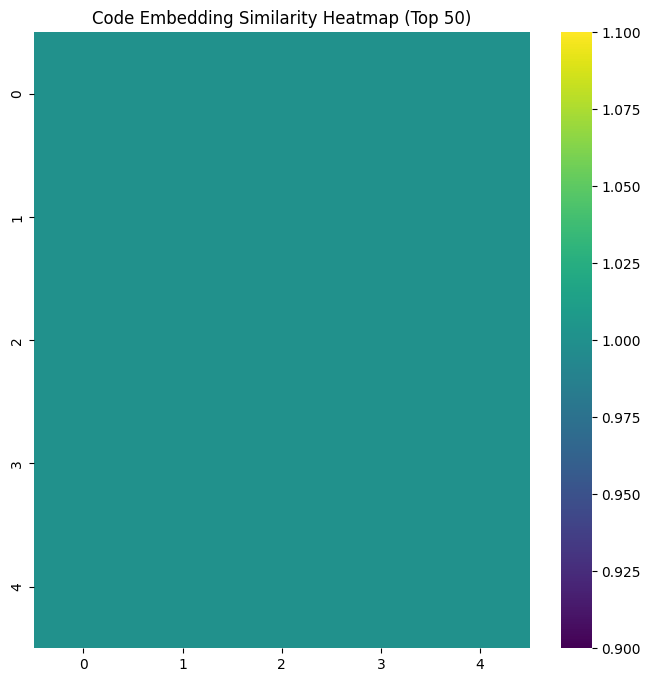

In [100]:

from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(embeddings[:5])  # ตัวอย่าง 50 โค้ด
plt.figure(figsize=(8,8))
sns.heatmap(sim, cmap="viridis")
plt.title("Code Embedding Similarity Heatmap (Top 50)")
plt.show()


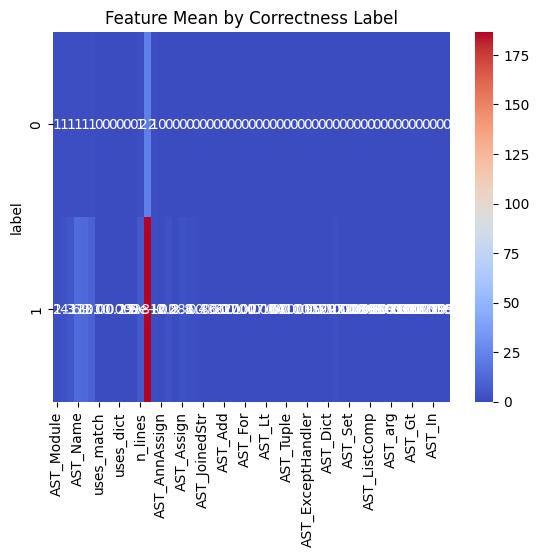

In [98]:
heat_df = data.groupby("label")[NUM_COLS].mean()
sns.heatmap(heat_df, annot=True, cmap="coolwarm")
plt.title("Feature Mean by Correctness Label")
plt.show()


In [108]:
plt.figure(figsize=(10,6))
sns.heatmap(data.pivot_table(values="prob_correct", index="cluster", aggfunc="mean"), annot=True, cmap="RdYlGn")
plt.title("Mean Model Confidence per Cluster")
plt.show()



KeyError: 'prob_correct'

<Figure size 1000x600 with 0 Axes>